In [ ]:
import os
import glob
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import CenterCrop
from torch.nn import Module, Conv2d, ReLU


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os
from google.colab import drive

# Mount Google Drive to access the files
drive.mount('/content/drive')

# Define paths on Google Drive
DRIVE_PATH = "/content/drive/MyDrive/pytorch_data"
EXTRACT_PATH = "/content/pytorch_data/carvana"  # Local directory for faster access

# Zip file locations on Google Drive
TRAIN_ZIP = os.path.join(DRIVE_PATH, "train.zip")
MASKS_ZIP = os.path.join(DRIVE_PATH, "train_masks.zip")

# Define local paths for extracted images
TRAIN_IMG_DIR = os.path.join(EXTRACT_PATH, "train_images")
TRAIN_MASK_DIR = os.path.join(EXTRACT_PATH, "train_masks")

# Ensure the directory structure exists in local storage
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_MASK_DIR, exist_ok=True)

# Check if files exist
if not os.path.exists(TRAIN_ZIP):
    print(f"File not found: {TRAIN_ZIP}")
else:
    print(f"Found: {TRAIN_ZIP}")

if not os.path.exists(MASKS_ZIP):
    print(f"File not found: {MASKS_ZIP}")
else:
    print(f"Found: {MASKS_ZIP}")

# Extract ZIP files to local storage
def extract_zip(zip_path, extract_to):
    if os.path.exists(zip_path):  # Check if the zip file exists
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted {zip_path} to {extract_to}")
    else:
        print(f"Zip file not found: {zip_path}")

# Extract training images and masks
extract_zip(TRAIN_ZIP, TRAIN_IMG_DIR)
extract_zip(MASKS_ZIP, TRAIN_MASK_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found: /content/drive/MyDrive/pytorch_data/train.zip
Found: /content/drive/MyDrive/pytorch_data/train_masks.zip
Extracted /content/drive/MyDrive/pytorch_data/train.zip to /content/pytorch_data/carvana/train_images
Extracted /content/drive/MyDrive/pytorch_data/train_masks.zip to /content/pytorch_data/carvana/train_masks


In [ ]:
!ls /content/pytorch_data/carvana/train_images/
#!ls /content/pytorch_data/carvana/train_masks/


In [ ]:
# ✅ 3. Extract ZIP files
'''
import zipfile

os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
os.makedirs(TRAIN_MASK_DIR, exist_ok=True)

with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_IMG_DIR)

with zipfile.ZipFile(MASKS_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_MASK_DIR)
'''



Fir flattening the image folder (once initially)

In [ ]:
# ✅ 4. Flatten nested folders (if train/train_masks inside zip)
!mv /content/pytorch_data/carvana/train_images/train/* /content/pytorch_data/carvana/train_images/
!mv /content/pytorch_data/carvana/train_masks/train_masks/* /content/pytorch_data/carvana/train_masks/
!rm -r /content/pytorch_data/carvana/train_images/train
!rm -r /content/pytorch_data/carvana/train_masks/train_masks


In [ ]:
print(TRAIN_IMG_DIR)
print(TRAIN_MASK_DIR)

/content/pytorch_data/carvana/train_images
/content/pytorch_data/carvana/train_masks


For loading the images

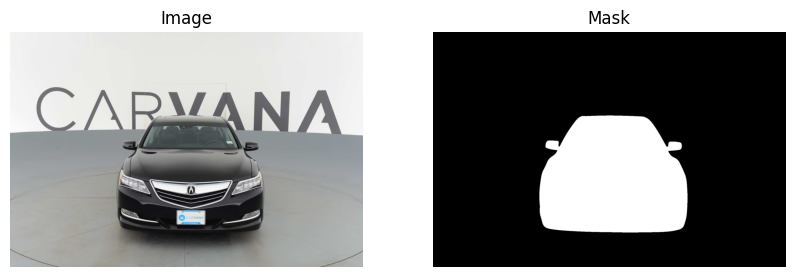

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# List image and mask files
image_files = sorted(os.listdir(TRAIN_IMG_DIR))
mask_files = sorted(os.listdir(TRAIN_MASK_DIR))

# Load first image and mask based on the pattern: image_name_mask.gif
for img_file in image_files:
    # Get the base name of the image (without the extension)
    base_name = os.path.splitext(img_file)[0]

    # Generate the corresponding mask filename
    mask_file = base_name + "_mask.gif"

    # Check if the mask exists in the mask directory
    if mask_file in mask_files:
        # Load the image and mask
        img = Image.open(os.path.join(TRAIN_IMG_DIR, img_file))
        mask = Image.open(os.path.join(TRAIN_MASK_DIR, mask_file))

        # Display the image and mask
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Image")
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis("off")
        plt.show()

        break  # Show only the first matching pair, remove this if you want to loop through all
    else:
        print(f"Mask for {img_file} not found!")


In [ ]:
import glob
import random # Import the random module

image_paths = sorted(glob.glob("/content/pytorch_data/carvana/train_images/*.jpg"))
mask_paths  = sorted(glob.glob("/content/pytorch_data/carvana/train_masks/*.gif"))


print(f"Images found: {len(image_paths)}")
print(f"Masks found : {len(mask_paths)}")



Images found: 5088
Masks found : 5088


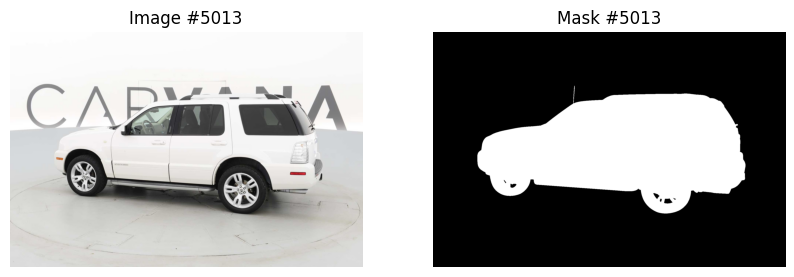

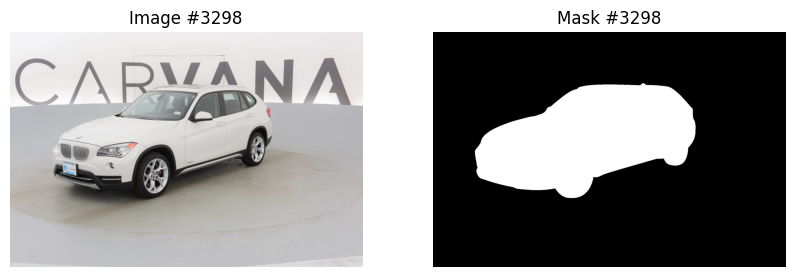

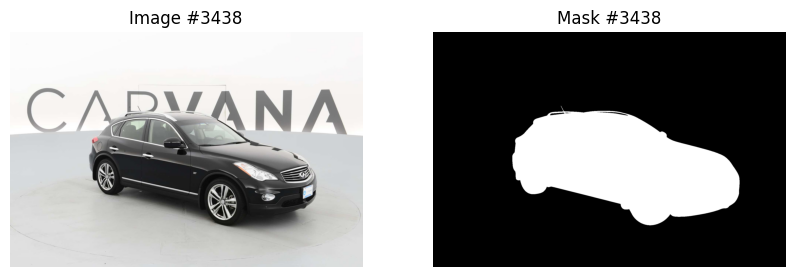

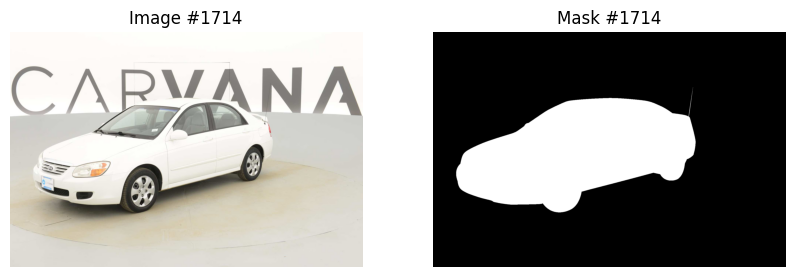

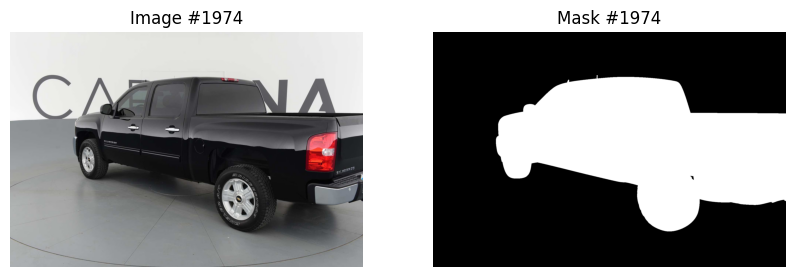

In [ ]:


# Number of samples to show
num_samples = 5

# Randomly select 10 indices from the dataset
random_indices = random.sample(range(len(image_paths)), num_samples)

for idx in random_indices:
    img = Image.open(image_paths[idx])
    mask = Image.open(mask_paths[idx])

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Image #{idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask #{idx}")
    plt.axis("off")

    plt.show()

In [ ]:
# ✅ 6. Split into train, val, test

train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.15, random_state=42)


train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_val_imgs, train_val_masks, test_size=0.15, random_state=42)

# Save test image paths to file for reproducibility
BASE_OUTPUT = "carvana_output"
os.makedirs(BASE_OUTPUT, exist_ok=True)
TEST_PATHS = os.path.join(BASE_OUTPUT, "test_image_paths.txt")

with open(TEST_PATHS, 'w') as f:
    for path in test_imgs:
        f.write(path + "\n")

print(f"Saved {len(test_imgs)} test image paths to {TEST_PATHS}")

print(f"Total images: {len(image_paths)}")
print(f"Train images: {len(train_imgs)}")
print(f"Val images:   {len(val_imgs)}")
print(f"Test images:  {len(test_imgs)}")

print(f"Total masks: {len(mask_paths)}")
print(f"Train masks: {len(train_masks)}")
print(f"Val masks:   {len(val_masks)}")
print(f"Test masks:  {len(test_masks)}")

Saved 764 test image paths to carvana_output/test_image_paths.txt
Total images: 5088
Train images: 3675
Val images:   649
Test images:  764
Total masks: 5088
Train masks: 3675
Val masks:   649
Test masks:  764


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PIN_MEMORY = True if DEVICE == "cuda" else False


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms=None):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        image = Image.open(self.imagePaths[idx]).convert("RGB")
        mask = Image.open(self.maskPaths[idx]).convert("L")  # grayscale

        if self.transforms:
            image = self.transforms(image)
            mask = self.transforms(mask)
            mask = (mask > 0).float()  # Ensure binary mask (0 or 1)

        return image, mask

In [ ]:
NUM_CHANNELS = 3
NUM_CLASSES = 1
NUM_LEVELS = 3

INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 16

INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

THRESHOLD = 0.5
BASE_OUTPUT = "/content/drive/MyDrive/pytorch_data/carvana/carvana_output"
os.makedirs(BASE_OUTPUT, exist_ok=True)

MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_carvana.pth")
PLOT_PATH = os.path.join(BASE_OUTPUT, "training_plot.png")
TEST_PATHS = os.path.join(BASE_OUTPUT, "test_image_paths.txt")

In [ ]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(outChannels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(outChannels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [ ]:

class Encoder(nn.Module):
    """UNet Encoder with skip connections"""
    def __init__(self, channels=(3, 16, 32, 64, 128)):
        super().__init__()
        self.encBlocks = nn.ModuleList([
            Block(channels[i], channels[i+1])
            for i in range(len(channels) - 1)
        ])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):

        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        return blockOutputs

In [ ]:

class Decoder(nn.Module):
    """UNet Decoder with skip connections"""
    def __init__(self, channels=(128, 64, 32, 16)):
        super().__init__()
        self.channels = channels

        # Upsampling layers
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2)
            for i in range(len(channels) - 1)
        ])

        # Decoder blocks after concatenation
        self.dec_blocks = nn.ModuleList([
            Block(channels[i+1] * 2, channels[i+1])  # *2 because of skip connection concatenation
            for i in range(len(channels) - 1)
        ])

    def forward(self, x, encFeatures):
        # encFeatures should be in reverse order (deepest to shallowest)
        for i in range(len(self.channels) - 1):
            # Upsample
            x = self.upconvs[i](x)

            # Get corresponding encoder feature
            encFeat = self.crop(encFeatures[i], x)

            # Concatenate
            x = torch.cat([x, encFeat], dim=1)

            # Apply decoder block
            x = self.dec_blocks[i](x)

        return x

    def crop(self, encFeatures, x):
        """Crop encoder features to match decoder feature size"""
        _, _, H, W = x.shape
        return torchvision.transforms.CenterCrop([H, W])(encFeatures)


In [ ]:

class UNet(nn.Module):
    """Complete UNet architecture"""
    def __init__(self, encChannels=(3, 16, 32, 64, 128),
                       decChannels=(128, 64, 32, 16),
                       nbClasses=1, retainDim=True,
                       outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
        super().__init__()

        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        # Encoder forward pass
        encFeatures = self.encoder(x)

        # Decoder forward pass (pass encoder features in reverse order)
        decFeatures = self.decoder(encFeatures[-1], encFeatures[:-1][::-1])

        # Final classification layer
        mask = self.head(decFeatures)

        # Resize to original input size if needed
        if self.retainDim:
            mask = F.interpolate(mask, size=self.outSize, mode='bilinear', align_corners=False)

        return mask

In [ ]:
# Define transformations (you might want to customize these)
transform = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
    transforms.ToTensor(),
])

trainDS = SegmentationDataset(train_imgs, train_masks, transforms=transform)
valDS = SegmentationDataset(val_imgs, val_masks, transforms=transform)
testDS = SegmentationDataset(test_imgs, test_masks, transforms=transform)

trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, pin_memory=PIN_MEMORY)
valLoader = DataLoader(valDS, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, shuffle=False, pin_memory=PIN_MEMORY)

In [ ]:
# Create a small subset of the training data for quick debugging
subset_size = 10
subset_imgs = train_imgs[:subset_size]
subset_masks = train_masks[:subset_size]

subsetDS = SegmentationDataset(subset_imgs, subset_masks, transforms=transform)
subsetLoader = DataLoader(subsetDS, batch_size=2, shuffle=True, pin_memory=PIN_MEMORY)

# Check if batches are loading and shapes are correct
for i, (images, masks) in enumerate(subsetLoader):
    print(f"Batch {i+1}: images shape = {images.shape}, masks shape = {masks.shape}")
    if i >= 2:  # Only check first 3 batches
        break

Batch 1: images shape = torch.Size([2, 3, 128, 128]), masks shape = torch.Size([2, 1, 128, 128])
Batch 2: images shape = torch.Size([2, 3, 128, 128]), masks shape = torch.Size([2, 1, 128, 128])
Batch 3: images shape = torch.Size([2, 3, 128, 128]), masks shape = torch.Size([2, 1, 128, 128])


In [ ]:
unet = UNet().to(DEVICE)


In [ ]:
# 4. Training function
import time # Import the time module
from tqdm import tqdm

def train_model(model, trainLoader, valLoader, num_epochs, device, save_path):
    """Train the UNet model"""

    # Loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=INIT_LR)

    # Training history
    history = {"train_loss": [], "val_loss": []}

    print("Starting training...")
    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in enumerate(trainLoader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Ensure mask dimensions match output
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)

            loss = criterion(outputs.squeeze(1), masks)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in valLoader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)

                if masks.dim() == 4 and masks.shape[1] == 1:
                    masks = masks.squeeze(1)


                loss = criterion(outputs.squeeze(1), masks)
                val_loss += loss.item()

        # Calculate average losses
        avg_train_loss = train_loss / len(trainLoader)
        avg_val_loss = val_loss / len(valLoader)

        # Store history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save model
    torch.save(model.state_dict(), save_path)

    end_time = time.time()
    print(f"\nTraining completed in {end_time - start_time:.2f} seconds")
    print(f"Model saved to: {save_path}")

    return history


In [ ]:
'''import os

print("MODEL_PATH:", MODEL_PATH)
if os.path.exists(MODEL_PATH):
    print("✅ Model file exists at the specified path.")
else:
    print("❌ Model file NOT found at the specified path.")'''

i changed unet to history,but model was trained with unet and parametrs saved


In [ ]:
history = train_model(unet, trainLoader, valLoader, num_epochs=40, device=DEVICE, save_path=MODEL_PATH)


Starting training...


Training Progress:  12%|█▎        | 5/40 [36:51<4:16:44, 440.13s/it]

Epoch [5/40]
Train Loss: 0.0183, Val Loss: 0.0211


Training Progress:  25%|██▌       | 10/40 [1:13:04<3:37:17, 434.58s/it]

Epoch [10/40]
Train Loss: 0.0144, Val Loss: 0.0145


Training Progress:  38%|███▊      | 15/40 [1:49:39<3:03:04, 439.38s/it]

Epoch [15/40]
Train Loss: 0.0119, Val Loss: 0.0124


Training Progress:  50%|█████     | 20/40 [2:26:17<2:26:14, 438.71s/it]

Epoch [20/40]
Train Loss: 0.0092, Val Loss: 0.0106


Training Progress:  62%|██████▎   | 25/40 [3:02:59<1:50:21, 441.42s/it]

Epoch [25/40]
Train Loss: 0.0082, Val Loss: 0.0101


Training Progress:  75%|███████▌  | 30/40 [3:40:37<1:15:15, 451.58s/it]

Epoch [30/40]
Train Loss: 0.0073, Val Loss: 0.0093


Training Progress:  88%|████████▊ | 35/40 [4:18:03<37:19, 447.85s/it]

Epoch [35/40]
Train Loss: 0.0092, Val Loss: 0.0090


Training Progress: 100%|██████████| 40/40 [4:54:58<00:00, 442.46s/it]

Epoch [40/40]
Train Loss: 0.0060, Val Loss: 0.0090



Training completed in 17701.53 seconds
Model saved to: /content/drive/MyDrive/pytorch_data/carvana/carvana_output/unet_carvana.pth


In [ ]:
# Recreate the model architecture
model = UNet().to(DEVICE)

# Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

UNet(
  (encoder): Encoder(
    (encBlocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Block(
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (bn1): Batc

In [ ]:


'''trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

H = {"train_loss": [], "test_loss": []}'''


In [ ]:
# Grab a single batch from trainLoader
x, y = next(iter(trainLoader))
x = x.to(DEVICE)

# Assuming you have your encoder and decoder defined separately:
with torch.no_grad():
    enc_features = unet.encoder(x)  # get encoder outputs
    print("Encoder feature shapes:")
    for i, feat in enumerate(enc_features):
        print(f"Encoder output {i}: {feat.shape}")

    # Now pass through decoder step-by-step with prints inside
    dec_input = enc_features[-1]
    for i in range(len(unet.decoder.channels) - 1):
        upconv_out = unet.decoder.upconvs[i](dec_input)
        print(f"Upconv[{i}] output shape: {upconv_out.shape}")

        skip_feat = unet.decoder.crop(enc_features[-(i+2)], upconv_out)
        print(f"Skip connection feature shape: {skip_feat.shape}")

        cat = torch.cat([upconv_out, skip_feat], dim=1)
        print(f"Concatenated shape (upconv + skip): {cat.shape}")

        dec_input = unet.decoder.dec_blocks[i](cat)
        print(f"Decoder block[{i}] output shape: {dec_input.shape}")


Encoder feature shapes:
Encoder output 0: torch.Size([16, 16, 128, 128])
Encoder output 1: torch.Size([16, 32, 64, 64])
Encoder output 2: torch.Size([16, 64, 32, 32])
Encoder output 3: torch.Size([16, 128, 16, 16])
Upconv[0] output shape: torch.Size([16, 64, 32, 32])
Skip connection feature shape: torch.Size([16, 64, 32, 32])
Concatenated shape (upconv + skip): torch.Size([16, 128, 32, 32])
Decoder block[0] output shape: torch.Size([16, 64, 32, 32])
Upconv[1] output shape: torch.Size([16, 32, 64, 64])
Skip connection feature shape: torch.Size([16, 32, 64, 64])
Concatenated shape (upconv + skip): torch.Size([16, 64, 64, 64])
Decoder block[1] output shape: torch.Size([16, 32, 64, 64])
Upconv[2] output shape: torch.Size([16, 16, 128, 128])
Skip connection feature shape: torch.Size([16, 16, 128, 128])
Concatenated shape (upconv + skip): torch.Size([16, 32, 128, 128])
Decoder block[2] output shape: torch.Size([16, 16, 128, 128])


In [ ]:
def test_model(model, test_loader, device):
    """Test the UNet model and calculate metrics"""

    model.eval()
    test_loss = 0.0
    total_samples = 0
    total_correct_pixels = 0
    total_pixels = 0

    # For IoU calculation
    intersection = 0.0
    union = 0.0

    criterion = nn.BCEWithLogitsLoss()

    print("Testing model...")

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing")):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Ensure mask dimensions match output
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)

            # Calculate loss
            loss = criterion(outputs.squeeze(1), masks)
            test_loss += loss.item()

            # Convert predictions to binary (0 or 1)
            pred_binary = (torch.sigmoid(outputs.squeeze(1)) > THRESHOLD).float()

            # Calculate pixel accuracy
            correct_pixels = (pred_binary == masks).sum().item()
            total_pixels_batch = masks.numel()

            total_correct_pixels += correct_pixels
            total_pixels += total_pixels_batch

            # Calculate IoU (Intersection over Union)
            intersection_batch = (pred_binary * masks).sum().item()
            union_batch = (pred_binary + masks - pred_binary * masks).sum().item()

            intersection += intersection_batch
            union += union_batch

            total_samples += images.size(0)

    # Calculate final metrics
    avg_test_loss = test_loss / len(test_loader)
    pixel_accuracy = total_correct_pixels / total_pixels
    iou = intersection / union if union > 0 else 0.0
    #dice_score = (2 * intersection) / (intersection + union + intersection) if (intersection + union + intersection) > 0 else 0.0
    dice_score = (2 * intersection) / (union + intersection) if (union + intersection) > 0 else 0.0


    print("\n" + "="*50)
    print("TEST RESULTS")
    print("="*50)
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Pixel Accuracy: {pixel_accuracy:.4f} ({pixel_accuracy*100:.2f}%)")
    print(f"IoU (Intersection over Union): {iou:.4f}")
    print(f"Dice Score: {dice_score:.4f}")
    print(f"Total test samples: {total_samples}")
    print("="*50)

    return {
        'test_loss': avg_test_loss,
        'pixel_accuracy': pixel_accuracy,
        'iou': iou,
        'dice_score': dice_score,
        'total_samples': total_samples
    }





In [ ]:
from tqdm import tqdm

unet.eval()
test_results = test_model(unet, testLoader, DEVICE)

Testing model...


Testing: 100%|██████████| 48/48 [00:53<00:00,  1.11s/it]


TEST RESULTS
Test Loss: 0.0088
Pixel Accuracy: 0.9966 (99.66%)
IoU (Intersection over Union): 0.9855
Dice Score: 0.9927
Total test samples: 764


In [ ]:
# 6. Visualization function
def plot_training_history(history, save_path):
    """Plot and save training history"""
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()


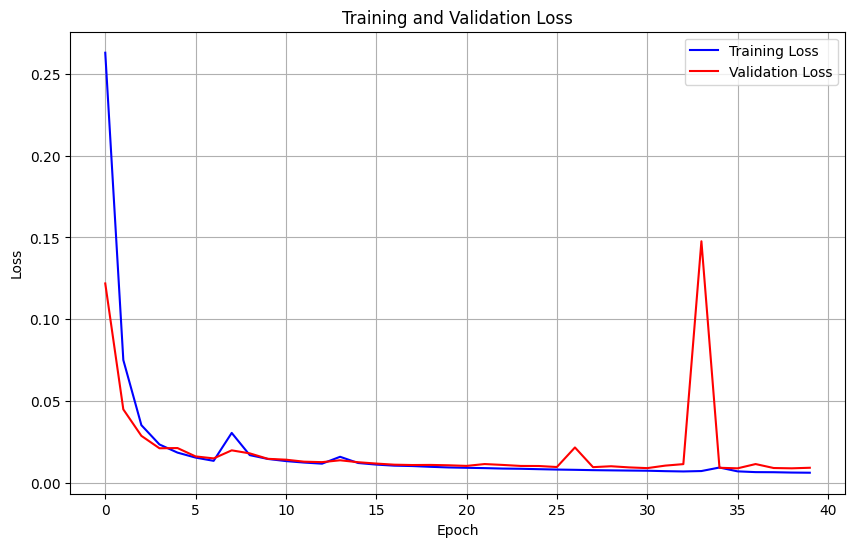

In [ ]:
plot_training_history(history, PLOT_PATH)

In [ ]:

def visualize_predictions(model, dataloader, device, num_samples=5):
    """Visualize model predictions"""
    model.eval()

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            if batch_idx >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)

            # Convert to CPU and numpy
            images = images.cpu()
            masks = masks.cpu()
            outputs = torch.sigmoid(outputs).cpu()

            # Plot first image in batch
            img = images[0].permute(1, 2, 0)
            true_mask = masks[0].squeeze() if masks[0].dim() > 2 else masks[0]
            pred_mask = outputs[0].squeeze()

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

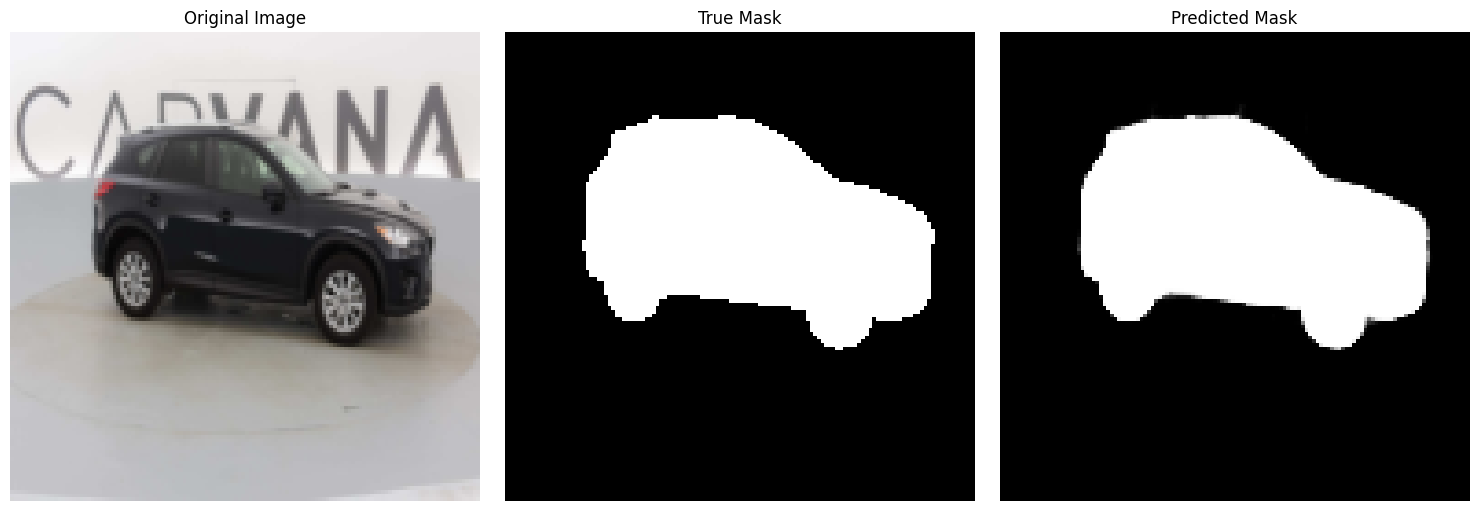

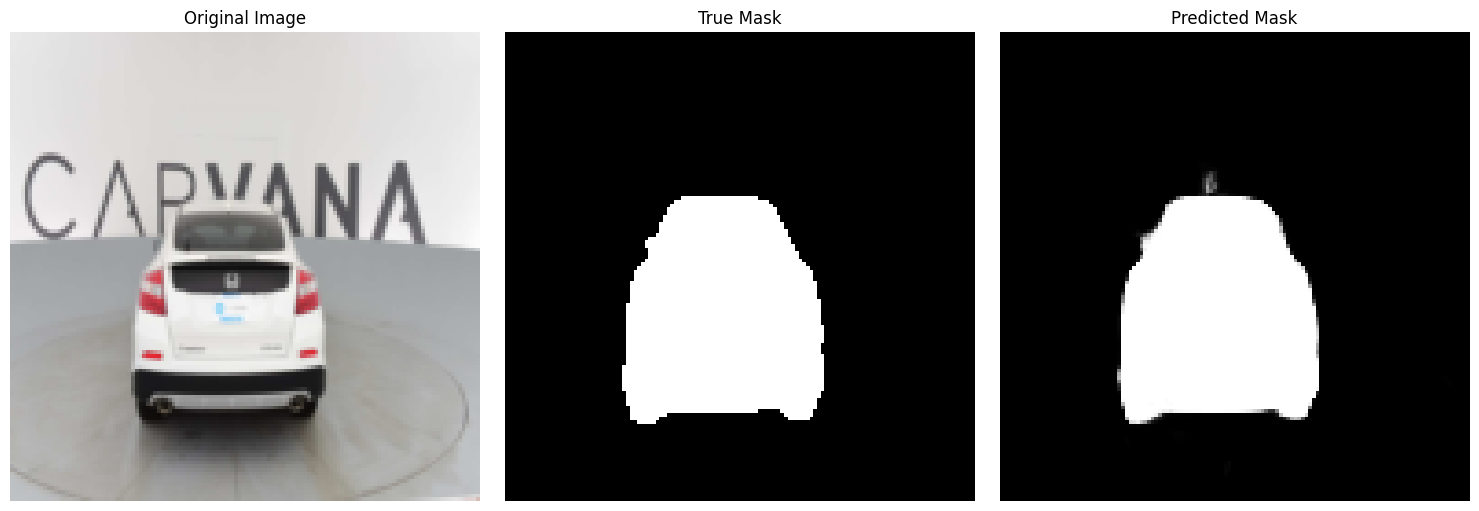

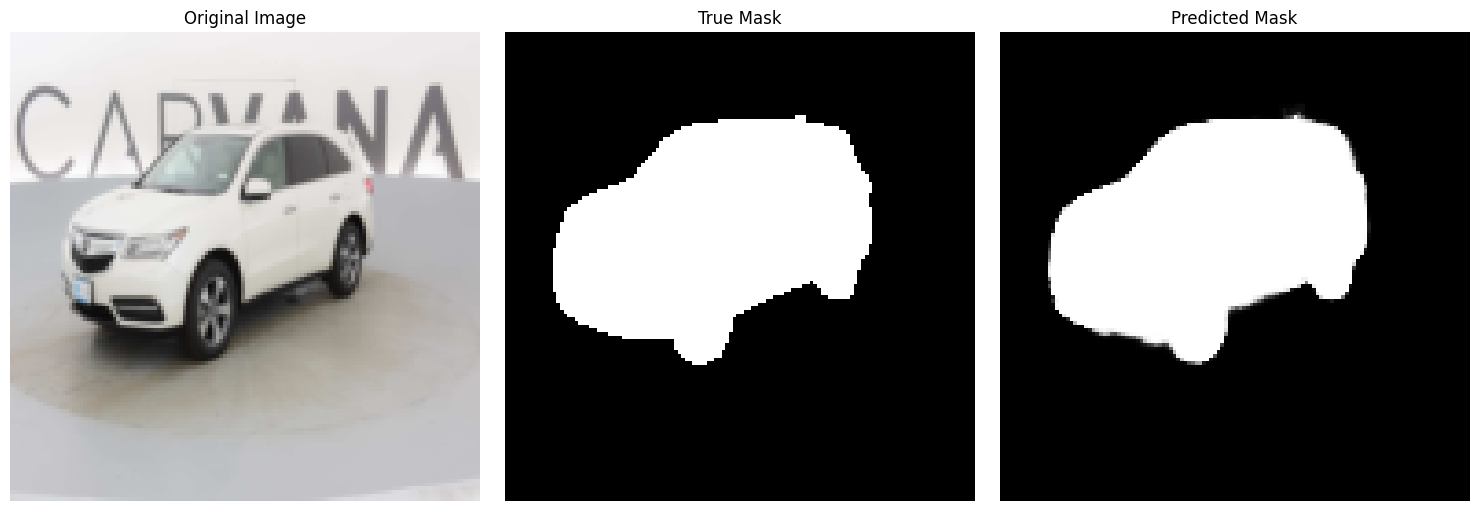

In [ ]:
visualize_predictions(unet, testLoader, DEVICE, num_samples=3)

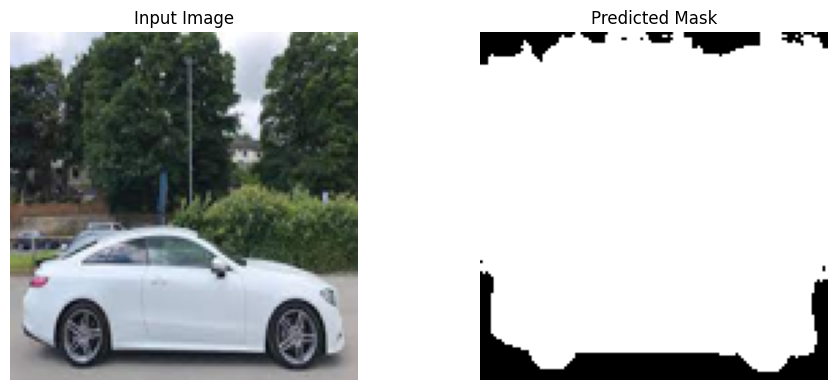

In [ ]:
#Testing with a new image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# Set image dimensions used during training
INPUT_IMAGE_HEIGHT = 128
INPUT_IMAGE_WIDTH = 128

# =========================
# Define Model Architecture
# =========================

class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, padding='same')
        self.bn1 = nn.BatchNorm2d(outChannels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, padding='same')
        self.bn2 = nn.BatchNorm2d(outChannels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class Encoder(nn.Module):
    def __init__(self, channels=(3, 16, 32, 64, 128)):
        super().__init__()
        self.encBlocks = nn.ModuleList([
            Block(channels[i], channels[i+1])
            for i in range(len(channels) - 1)
        ])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        blockOutputs = []
        for block in self.encBlocks:
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
        return blockOutputs

class Decoder(nn.Module):
    def __init__(self, channels=(128, 64, 32, 16)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([
            nn.ConvTranspose2d(channels[i], channels[i+1], kernel_size=2, stride=2)
            for i in range(len(channels) - 1)
        ])
        self.dec_blocks = nn.ModuleList([
            Block(channels[i+1]*2, channels[i+1])
            for i in range(len(channels) - 1)
        ])

    def forward(self, x, encFeatures):
        for i in range(len(self.channels) - 1):
            x = self.upconvs[i](x)
            encFeat = self.crop(encFeatures[i], x)
            x = torch.cat([x, encFeat], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, encFeatures, x):
        _, _, H, W = x.shape
        return torchvision.transforms.CenterCrop([H, W])(encFeatures)

class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64, 128),
                       decChannels=(128, 64, 32, 16),
                       nbClasses=1, retainDim=True,
                       outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        self.head = nn.Conv2d(decChannels[-1], nbClasses, kernel_size=1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[-1], encFeatures[:-1][::-1])
        mask = self.head(decFeatures)
        if self.retainDim:
            mask = F.interpolate(mask, size=self.outSize, mode='bilinear', align_corners=False)
        return mask

# ========================
# Load Saved Model Weights
# ========================

model = UNet()
model.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
model.eval()

# =====================
# Load and Preprocess Image
# =====================

# Replace with your actual image path
image_path = "/content/car_image.jpg"

# Preprocessing
transform = transforms.Compose([
    transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
    transforms.ToTensor(),  # Converts to [0,1] and channels-first
])

img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0)  # Add batch dimension: [1, 3, H, W]

# ====================
# Inference and Mask
# ====================

with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output)
    binary_mask = (pred_mask > 0.5).float()

# ====================
# Visualize Input and Mask
# ====================

plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img.resize((INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT)))
plt.title("Input Image")
plt.axis("off")

# Predicted mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask.squeeze().cpu(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
